<h1><center>Recommedation system</center></h1>
<h3><center>Movie recommendation system using Collaborative filtering</center></h3>

The aim of the project is to build a movie recommendation system using collaborative filtering methods. Collaborative filtering methods are methods that are solely based on users past interactions recorded between users and items. The interations have to be stored as user-item-interaction matrix. <br>

The dataset used is the popular MovieLens dataset. It contains the following columns:-
* userId : Unique identifier for user
* movieId : Unique identifier for movie
* rating : Rating of movie given by user
* timestamp : Time of rating

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from surprise.accuracy import mse, mae
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset, SVD 
from collections import defaultdict

The dataset is read into a dataframe and the timestamp column is removed since no temporal information is important for this method.

In [2]:
df = pd.read_csv('/home/raj/Downloads/ratings.csv')
df.drop('timestamp', axis= 1, inplace= True)
df.head(5)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Before further pre-processing, it is important to check for Null values and remove them. The dataset is very clean, with no missing values.

In [3]:
df.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [4]:
print("Number of unique movies:", df.movieId.nunique())
print("Number of unique users:", df.userId.nunique())

Number of unique movies: 9724
Number of unique users: 610


There are 610 unique users in the dataset and 9724 unique movies listed. Considering a static snapshot of the system, there are 9724 movies to recommend to 610 users. Some movies have already been rated by these users, thus the remaning movies (not rated by a particular user) are open for recommendations to that user.
The dataset contains 100836 rows i.e. that many user-item interactions. Total possible values in the matrix are 610x9724. Thus the matrix is a sparse matrix.<br>

For a sparse matrix, the sparsity is calculated. The sparsity gives the percentage of 0 or None values in the matrix. The available ratings are the user-movie rating that are not None or 0. Total ratings are the total values of the matrix - 610x9724. Thus sparsity is calculated as:-

  $\dfrac{availableRatings - totalRatings}{totalRatings} * 100$

In [5]:
available_ratings = df.rating.count()
total_ratings = df.movieId.nunique() * df.userId.nunique()
missing_ratings = total_ratings - available_ratings
sparsity = (missing_ratings/total_ratings) * 100
print("Sparsity in the ratings:", sparsity)

Sparsity in the ratings: 98.30003169443864


There is about 98.3% sparsity in the user-movie matrix. This is within the limits. The model used can handle upto 95% sparsity in the dataset. The below visualization is the histogram for the rating values. This gives a sense of the upper and lower limit of ratings given by users. 

Text(0.5, 0, 'rating')

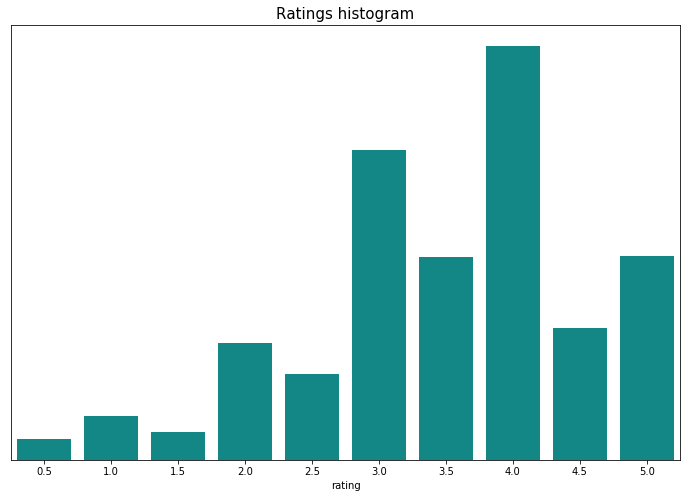

In [6]:
dist = df.rating.value_counts()
plt.figure(figsize=(12,8))
sns.barplot(x= dist.index, y= dist.values, color= '#009999')
plt.title('Ratings histogram', fontdict= {'size':15})
plt.yticks([])
plt.xlabel('rating')

The ratings range from 0.5 to 5.0, with ratings 3 to 5 the most frequent amongst all.<br>

The recommendation system works poorly when there isn't enough interactions of a user or of an item. Meaning, a user only rated 2 movies in the lifetime, cannot possibly get accurate recommendation, similarly, a movie rated just twice cannot be used for accurate recommendation. Simply because there isn't enought data (cold start problem). Such cases can be handled separately using a random strategy, maximum expectation startegy, exploratory strategy etc.<br>

For the problem in hand, all users who have not rated more than 3 movies and all movies which haven't been rated more than 3 times are removed from the dataset. This leaves those users and movies which are suitable to be considered for past interactions based collaborative filtering.

In [7]:
filter_movies = df.movieId.value_counts() > 3
filter_movies = filter_movies[filter_movies].index.tolist()

filter_users = df.userId.value_counts() > 3
filter_users = filter_users[filter_users].index.tolist()

print("Original dimensions:", df.shape)
df = df[(df.movieId.isin(filter_movies)) & (df.userId.isin(filter_users))]
print("New dimensions:", df.shape)

Original dimensions: (100836, 3)
New dimensions: (92394, 3)


About 8442 rows were removed from the dataset. This is about 8% reduction in the dataset which is acceptable.<br>

The `Reader` class is used parse a file containing user-item-interactions per line and to specify the range of teg ratings, here (0.5,5). The format of each line by default has to be `user item rating`. The `Dataset` class provides methods to read datasets from various sources, in this case from a pandas dataframe. The object of `Reader` class is passed to this to specify the format in which each row of the dataframe should be read as.<br>

Once the dataset is read into the format required by the model, the train and test sets are created. The entire dataset is used as a train set since that is the past information of each user and their ratings for movies. The anti-set (testset) is the set of all user-item pairs which are 0 or None in the sparse matrix (basically, the rating information the dataset does not have). The model will predict the value of rating at these locations.

In [8]:
cols = ['userId', 'movieId', 'rating']
reader = Reader(rating_scale= (0.5,5))
data = Dataset.load_from_df(df[cols],reader)

train_set = data.build_full_trainset()
antiset = train_set.build_anti_testset()

The SVD model is used for the recommender system. It factorizes the input matrix via Stocahstic Gradient descent. The model will run 25 epochs on the train set. To understand the performance of the model, it cross-validated with k=5 on the entire data. The RMSE and MAE values are reported for each fold.

In [9]:
mod = SVD(n_epochs= 25, verbose= True)
cross_validate(mod, data, measures= ['MAE','RMSE'], cv= 5, verbose= True)
print("Training complete")

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
P

The trained model gives an average MAE value of 0.65 and an average RMSE value of 0.86 on the test set. This is not a very bad fit. Thus now, the trained model is used to make predictions on the anti-set. For each user and movie pair not present in initial data, a prediction is made.<br>
The function below, makes a dictionary of users with each user having a list of (movie,rating) tuples. It sorts the list in descending order by rating and returns the top 'n' movies that are to be recommended to that user.

In [10]:
def get_top_n_predictions(predictions,n):
    """
    Return top 'n' predicted ratings for each user
    
    parameters:
        predictions: list of Predictions.Prediction, predictions from the model.
        
        n: int. number of top predictions.
        
    returns:
        top_pred: dict. User and top 'n' predicted ratings for each.
    """
    top_pred = defaultdict(list)
    
    for uid, iid, _, est,_ in pred:
        top_pred[uid].append((iid,est))
        
    for uid, user_rating in top_pred.items():
        user_rating.sort(key= lambda x: x[1], reverse= True)
        top_pred[uid] = user_rating[:n]
        
    return top_pred

In [11]:
pred = mod.test(antiset)
top_n = get_top_n_predictions(pred,3)

The top 3 recommendations for all users is stored in the `top_n` dictionary. The function below returns the recommendations for the users specified. This function is the interface to retrieve user specific recommendations from the model based on the entire static system of users and movies.

In [31]:
def get_user_recommendations(user):
    """
    Returns the recommendations for users specified
    
    parameters:
        user: list. userId
        
    returns:
        recommend: list. List of movieId recommended by model
    """
    recommend = {}
    for uid in user:
        recommend[uid] = [iid for iid,_ in top_n[uid]]

    return recommend

In [32]:
user_recommendations = get_user_recommendations([56,84,90,357])
for uid, user_ratings in user_recommendations.items():
    print(f"User {uid}", user_ratings)

User 56 [750, 475, 898]
User 84 [110, 1086, 3508]
User 90 [858, 7361, 3508]
User 357 [750, 1261, 3703]


For 4 users the corresponding recommendations are given as a list of movieIds as seen above. Thus the recommendation system is now ready to be queried by userIds. This completes the project for a recommendation system using collaborative filtering methods.